# Performance of LLMs on the LAB-Bench benchmark
This notebook examines the performance of various large language models (LLMs) on the LAB-Bench dataset.

Hugging Face dataset: https://huggingface.co/datasets/futurehouse/lab-bench
* We use the CloningScenarios subset.

Paper: https://arxiv.org/abs/2407.10362

## Setup

In [8]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime

In [9]:
results_df_path = 'results.csv'

log_files_dir = 'logs/'
models_data_file = '../../../models/models_data.tsv'

large_scale_models_file = '../../../models/epoch-data/large_scale_ai_models.csv'
notable_models_file = '../../../models/epoch-data/notable_ai_models.csv'

## Process metadata
First, we merge two Epoch datasets containing model metadata into a single dataframe. 

[1] https://epochai.org/data/large-scale-ai-models  
[2] https://epochai.org/data/notable-ai-models

In [10]:
def merge_epoch_datasets(notable_file, large_scale_file):
    """"""
    
    notable_df = pd.read_csv(notable_file)
    large_scale_df = pd.read_csv(large_scale_file)
    epoch_df = pd.concat([notable_df, large_scale_df], ignore_index=True)
    epoch_df = epoch_df.drop_duplicates(subset='System', keep='first')
    return epoch_df

epoch_data = merge_epoch_datasets(notable_models_file, large_scale_models_file)

print(f"Total number of models in epoch data: {len(epoch_data)}")
epoch_data.head()

Total number of models in epoch data: 959


,System,Domain,Organization,Authors,Publication date,Reference,Link,Notability criteria,Notability criteria notes,Training dataset notes,...,Base model,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes
0,AFM-server,Language,Apple,"Andy Narayanan, Aonan Zhang, Bowen Zhang, Chen...",2024-07-29,Apple Intelligence Foundation Language Models,https://machinelearning.apple.com/research/app...,Significant use,"Currently in beta access only, but will be int...","6.3T tokens of web text, code, and math, plus ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFM-on-device,Language,Apple,"Andy Narayanan, Aonan Zhang, Bowen Zhang, Chen...",2024-07-29,Apple Intelligence Foundation Language Models,https://machinelearning.apple.com/research/app...,Significant use,"Currently in beta access only, but will be int...",188B of tokens are used to train a pruning mas...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Llama 3.1-405B,Language,Meta AI,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...",2024-07-23,The Llama 3 Herd of Models,https://ai.meta.com/research/publications/the-...,"SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ESM3 (98B),Biology,"EvolutionaryScale,UC Berkeley","Thomas Hayes, Roshan Rao, Halil Akin, Nicholas...",2024-06-25,ESM3: Simulating 500 million years of evolutio...,https://www.evolutionaryscale.ai/blog/esm3-rel...,Historical significance,Largest (in compute) biology and protein model...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Claude 3.5 Sonnet,"Multimodal,Language,Vision",Anthropic,NaN,2024-06-20,Claude 3.5 Sonnet,https://www-cdn.anthropic.com/fed9cc193a14b841...,"Significant use,SOTA improvement","""It also sets new performance standards in eva...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we load data I personally compiled, which contains cost per M tokens and creates a mapping between the Epoch and Inspect model names. This gets merged with the Epoch data to make our complete metadata table.

In [11]:
models_df = pd.read_csv(models_data_file, sep='\t')

models_metadata = models_df.merge(epoch_data, left_on='epoch_model_name', right_on='System', how='left')
models_metadata.head()

,inspect_model_name,epoch_model_name,biggest_in_class,cost_per_M_tokens,input_cost_per_M_tokens,output_cost_per_M_tokens,cost_source,api_source,last_updated,System,...,Base model,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes
0,google/gemini-1.5-flash,NaN,0,NaN,$0.08,$0.30,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,google/gemini-1.5-pro,Gemini 1.5 Pro,1,NaN,$3.50,$10.50,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03,Gemini 1.5 Pro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,google/gemini-1.0-pro,Gemini 1.0 Pro,1,NaN,$0.50,$1.50,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03,Gemini 1.0 Pro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,openai/gpt-4,GPT-4,1,NaN,$30.00,$60.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03,GPT-4,...,NaN,NaN,NaN,NaN,4.058659e+07,NaN,NaN,NaN,NaN,NaN
4,openai/gpt-4-turbo,GPT-4 Turbo,1,NaN,$10.00,$30.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03,GPT-4 Turbo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load results from Inspect
Load the contents of a log directory into a dataframe

In [12]:
def clean_cost(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    return float(value)

def calculate_cost(input_tokens, output_tokens, model_name, models_df):
    model_data = models_df[models_df['inspect_model_name'] == model_name].iloc[0]
    input_cost_per_M = clean_cost(model_data['input_cost_per_M_tokens'])
    output_cost_per_M = clean_cost(model_data['output_cost_per_M_tokens'])
    cost_per_M = clean_cost(model_data['cost_per_M_tokens'])
    
    if input_cost_per_M and output_cost_per_M:
        input_cost = (input_cost_per_M / 1_000_000) * input_tokens
        output_cost = (output_cost_per_M / 1_000_000) * output_tokens
        total_cost = input_cost + output_cost
    elif cost_per_M:
        total_cost = (cost_per_M / 1_000_000) * (input_tokens + output_tokens)
    else:
        total_cost = 0
    
    return round(total_cost, 2)

def process_log_files(log_files_dir):
    results = []
    
    for filename in os.listdir(log_files_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(log_files_dir, filename)
            with open(file_path, 'r') as f:
                log = json.load(f)
            
            if log['status'] == "success":
                model_name = log['eval']['model']
                
                # Extract data from logs
                accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                task_name = log['eval']['task']
                dataset_samples = log['eval']['dataset']['samples']
                completed_samples = log['results']['completed_samples']
                input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                start_time = log['stats']['started_at']
                end_time = log['stats']['completed_at']
                
                run_cost = calculate_cost(input_tokens, output_tokens, model_name, models_df)
                
                results.append({
                    'inspect_model_name': model_name,
                    'accuracy': accuracy,
                    'stderr': stderr,
                    'total_tokens': token_usage,
                    'input_tokens': input_tokens,
                    'output_tokens': output_tokens,
                    'task': task_name,
                    'dataset_samples': dataset_samples,
                    'completed_samples': completed_samples,
                    'run_id': log['eval']['run_id'],
                    'created': log['eval']['created'],
                    'start_time': start_time,
                    'end_time': end_time,
                    'filename': filename,
                    'estimated_cost': run_cost
                })
    
    return pd.DataFrame(results)

results_df = process_log_files(log_files_dir)
results_df.to_csv(results_df_path, index=False)

Finally, merge the model metadata with the Inspect results

In [6]:
labbench_df = results_df.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

# Identify unmatched models
unmatched_models = labbench_df[labbench_df['epoch_model_name'].isna()]['inspect_model_name'].unique()
print("Models from Inspect results without Epoch metadata", unmatched_models)
labbench_df.head()

Models from Inspect results without Epoch metadata []


,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,...,Base model,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes
0,openai/gpt-3.5-turbo,0.272727,0.078730,170540,170379,161,benchmarks/lab_bench,33,33,kMCBUHnAofKnpy8w3sFwRP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,together/meta-llama/Meta-Llama-3.1-405B-Instru...,0.515152,0.088348,200183,197704,2479,benchmarks/lab_bench,33,33,jhF2BY7YnjG6sSTGkJmbFi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,together/meta-llama/Meta-Llama-3-70B-Instruct-...,0.151515,0.063383,80484,80324,160,benchmarks/lab_bench,33,33,92asLcsX3cyuRoBAsUfVkx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,together/meta-llama/Llama-2-13b-chat-hf,0.000000,0.000000,13553,10583,2970,benchmarks/lab_bench,33,33,K8ZMVdhvw3UTk8acuLMrvE,...,NaN,NaN,NaN,NaN,NaN,Language modelling,Industry,Unreleased,NaN,Llama 2 license. can't use outputs to train mo...
4,anthropic/claude-2.0,0.393939,0.086377,164275,162038,2237,benchmarks/lab_bench,33,33,bmbo8dMPRbLBnJjWmtpv3F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cost analysis

In [7]:
cost_summary = labbench_df.groupby('inspect_model_name').agg({
    'estimated_cost': ['count', 'sum', 'mean'],
    'input_tokens': 'sum',
    'output_tokens': 'sum'
}).reset_index()
cost_summary.head()

cost_summary.columns = [
    'Model', 'Total Runs', 'Estimated Total Cost', 'Estimated Average Cost per Run',
    'Total Input Tokens', 'Total Output Tokens'
]

cost_summary = cost_summary[[
    'Model', 'Total Runs', 'Total Input Tokens', 'Total Output Tokens',
    'Estimated Total Cost', 'Estimated Average Cost per Run'
]]

print("Cost Analysis for CloningScenarios Benchmark:")
print(cost_summary.to_string(index=False))

# Calculate and display the grand total cost
grand_total_cost = cost_summary['Estimated Total Cost'].sum()
print(f"\nEstimated Total Cost for all models: ${grand_total_cost:.2f}")

Cost Analysis for CloningScenarios Benchmark:
                                                 Model  Total Runs  Total Input Tokens  Total Output Tokens  Estimated Total Cost  Estimated Average Cost per Run
                                  anthropic/claude-2.0           1              162038                 2237                  1.35                            1.35
                  anthropic/claude-3-5-sonnet-20240620           1              215079                  199                  0.65                            0.65
                      anthropic/claude-3-opus-20240229           1              215079                  200                  3.24                            3.24
                                 google/gemini-1.0-pro           1              161264                  127                  0.08                            0.08
                                 google/gemini-1.5-pro           1              161264                   99                  0.57               

## Model performance on LAB-Bench CloningScenarios

In [1]:
from datasets import load_dataset
import numpy as np

def compute_cloning_random_baseline():
    # Load the LitQA2 dataset
    dataset = load_dataset("futurehouse/lab-bench", name="CloningScenarios", split="train")
    
    # Calculate the number of options for each question
    num_options = [len(record['distractors']) + 1 for record in dataset]  # +1 for the correct answer
    
    # Calculate the probability of guessing correctly for each question
    probabilities = [1/n for n in num_options]
    
    # Compute the average probability
    random_guess_baseline = np.mean(probabilities)
    
    return random_guess_baseline

# Call the function and print the result
baseline = compute_cloning_random_baseline()
print(f"Random guess baseline accuracy for CloningScenarios: {baseline:.4f}")

Random guess baseline accuracy for CloningScenarios: 0.2259


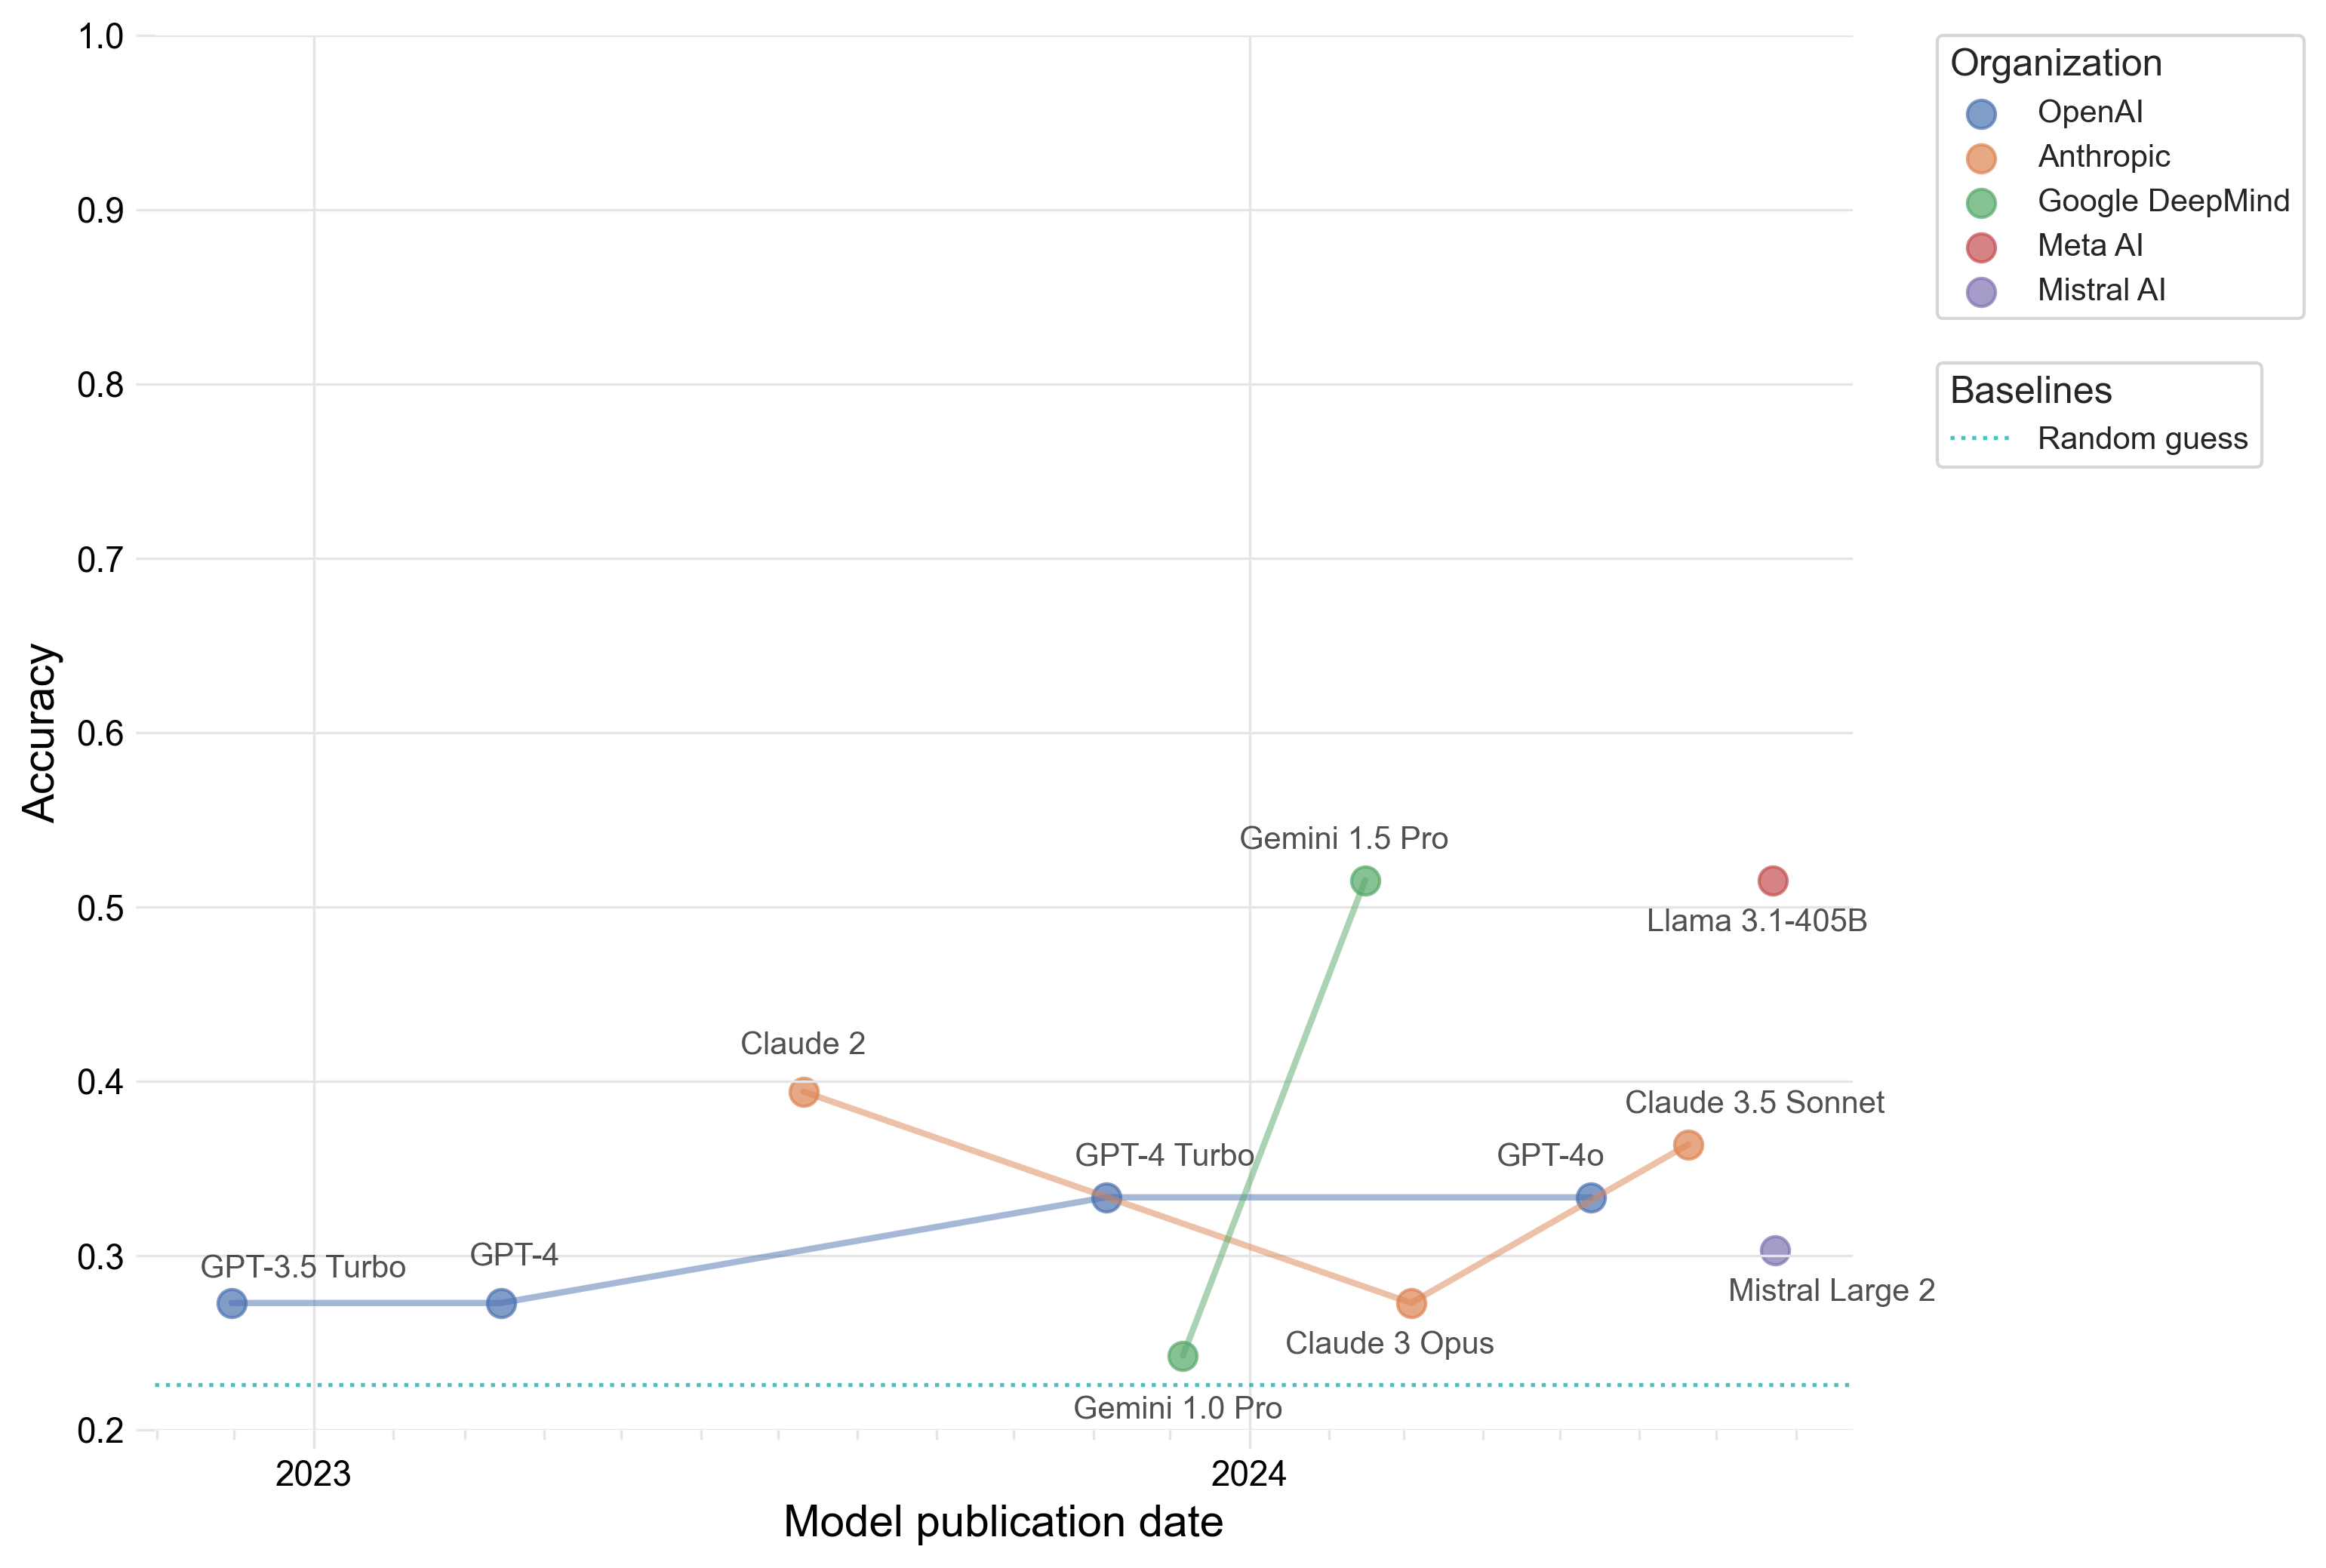

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

# Function to parse dates
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except:
        return None

# Prepare the data
plot_data = labbench_df.copy()
plot_data['Publication date'] = plot_data['Publication date'].apply(parse_date)
plot_data['accuracy'] = plot_data['accuracy'].astype(float)
plot_data['stderr'] = plot_data['stderr'].astype(float)

models_to_exclude = ["Llama 2-13B", "Llama 3-70B"]

# Filter for models with biggest_in_class = 1
largest_models = plot_data[
    (plot_data['biggest_in_class'] == 1) & 
    (~plot_data['epoch_model_name'].isin(models_to_exclude))
].sort_values('Publication date')

manual_offsets = {
    "GPT-3.5 Turbo": (-10, 6),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-10, 8),
    "GPT-4o": (-30, 8),
    "Claude 2": (-20, 10),
    "Claude 3 Opus": (-40, -18),
    "Claude 3.5 Sonnet": (-20, 8),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-20, -20),
    "Llama 3.1-405B": (-40, -18),
    "Gemini 1.0 Pro": (-35, -22),
    "Gemini 1.5 Pro": (-40, 8),
    "Mixtral 8x7B": (-40, 8),
    "Mistral Large 2": (-15, -18)
}

# Set plot style for publication-quality figure
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['axes.edgecolor'] = 'gray'

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("deep")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a color map for organizations
organizations = largest_models['Organization'].unique()
color_map = dict(zip(organizations, sns.color_palette("deep", len(organizations))))

# Plot the data
for org in organizations:
    org_data = largest_models[largest_models['Organization'] == org]
    ax.scatter(org_data['Publication date'], org_data['accuracy'], 
               label=org, color=color_map[org], s=80, alpha=0.7)
    ax.plot(org_data['Publication date'], org_data['accuracy'], linewidth=2,
            color=color_map[org], alpha=0.5)
    
    for _, row in org_data.iterrows():
        offset = manual_offsets.get(row['epoch_model_name'], (5, 5))
        ax.annotate(row['epoch_model_name'], 
                    (row['Publication date'], row['accuracy']),
                    xytext=offset, textcoords='offset points',
                    fontsize=10, alpha=0.8, rotation=0, ha='left', va='bottom')
        
ax.axhline(y=baseline, color='#00a9a5', linestyle=':', alpha=0.7, linewidth=1.3, label='Random guess')

# Customize the plot
# ax.set_title("Model Performance on CloningScenarios Benchmark", fontsize=16, fontweight='bold')
ax.set_xlabel("Model publication date", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_ylim(0.2, 1)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Adjust grid properties
ax.grid(True, axis='both', color='#E5E5E5', linestyle='-', linewidth=0.8, alpha=1)
ax.grid(True, axis='x', which='major', color='#E5E5E5', linestyle='-', linewidth=0.8, alpha=1)
ax.grid(False, axis='x', which='minor')  # Turn off minor x grid

# Customize tick parameters
ax.tick_params(which='major', length=6, width=0.8, color='#E5E5E5', direction='out')
ax.tick_params(which='minor', length=3, width=0.8, color='#E5E5E5', direction='out')

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Make sure both major and minor ticks are visible
ax.tick_params(which='both', bottom=True, top=False, left=True, right=False)

# Remove labels for minor ticks (months)
ax.xaxis.set_tick_params(which='minor', bottom=True, top=False, labelbottom=False)

# Rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

# Create two separate legends
# Legend for baselines
org_handles, org_labels = ax.get_legend_handles_labels()
baseline_handles = org_handles[len(organizations):]
baseline_labels = org_labels[len(organizations):]
baseline_legend = ax.legend(baseline_handles, baseline_labels, 
                            title="Baselines", title_fontsize='12', fontsize='10', 
                            loc='upper left', bbox_to_anchor=(1.05, 0.765), borderaxespad=0.)
baseline_legend._legend_box.align = "left"

# Add the first legend manually
ax.add_artist(baseline_legend)

# Legend for organizations
org_legend = ax.legend(org_handles[:len(organizations)], org_labels[:len(organizations)], 
                       title="Organization", title_fontsize='12', fontsize='10', 
                       loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=-0.)
org_legend._legend_box.align = "left"

# Adjust layout to make room for legends
plt.subplots_adjust(right=0.75)

# Save the figure
plt.savefig('cloning-performance-vs-time.png', dpi=300, bbox_inches='tight')
plt.show()

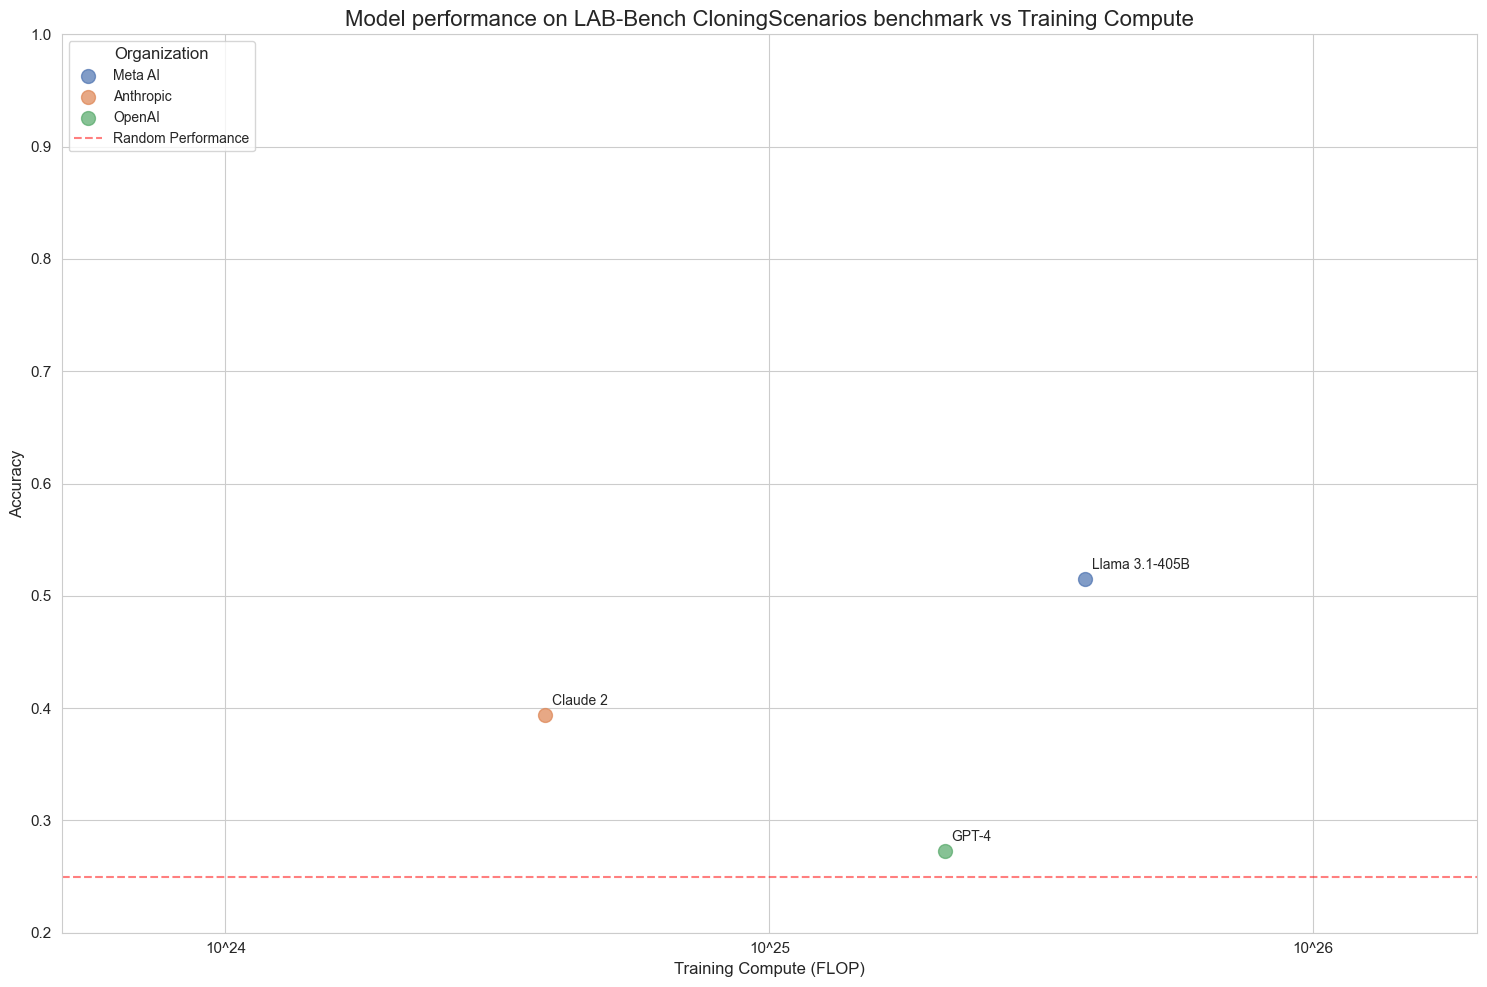

In [15]:
# Prepare the data
plot_data = labbench_df.copy()
plot_data = plot_data[plot_data['inspect_model_name'] != 'together/meta-llama/Llama-2-70b-hf']
plot_data['accuracy'] = plot_data['accuracy'].astype(float)
plot_data['stderr'] = plot_data['stderr'].astype(float)
plot_data['Training compute (FLOP)'] = plot_data['Training compute (FLOP)'].astype(float)

# Filter for models with biggest_in_class = 1 and non-null training compute
largest_models = plot_data[
    (plot_data['biggest_in_class'] == 1) & 
    (plot_data['Training compute (FLOP)'].notnull())
].sort_values('Training compute (FLOP)')

# Set up the plot style
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create a color map for organizations
organizations = largest_models['Organization'].unique()
color_map = dict(zip(organizations, sns.color_palette("deep", len(organizations))))

# Plot the data
for org in organizations:
    org_data = largest_models[largest_models['Organization'] == org]
    plt.scatter(org_data['Training compute (FLOP)'], org_data['accuracy'], 
                label=org, color=color_map[org], s=100, alpha=0.7)
    
    # Add model names as labels
    for _, row in org_data.iterrows():
        plt.annotate(row['epoch_model_name'], 
                     (row['Training compute (FLOP)'], row['accuracy']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=10, alpha=1, rotation=0, ha='left', va='bottom')

# Add random performance line
plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.5, label='Random Performance')

# Customize the plot
plt.title("Model performance on LAB-Bench CloningScenarios benchmark vs Training Compute", fontsize=16)
plt.xlabel("Training Compute (FLOP)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(title="Organization", title_fontsize='12', fontsize='10', loc='upper left')
plt.ylim(0.2, 1)

# Set x-axis to log scale and define custom ticks with padding
plt.xscale('log')
plt.xlim(5e23, 2e26)  # Add padding on both sides
plt.xticks([1e24, 1e25, 1e26], ['10^24', '10^25', '10^26'])

# Adjust layout and display
plt.tight_layout()
plt.savefig('cloning-performance-vs-compute.png', dpi=300)
plt.show()